In [ ]:
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU

In [ ]:
# Here instead of using a generator type of construct i am loading all the images at once to memory 
# this is ok for now as the images are 256*256 and require less memory we may need to update for larger images.
# I have noticed that GANs do not require a lot of training data like traditional Deep learning models 
# rather GANs prefer more epochs.

In [ ]:
# load all images from the directory into memory with appropriate preprocessing

def load_images(path, size=(256, 512)):
    (src_list, tar_list) = (list(), list())

    # enumerate filenames in directory, assuming all are images
    for filename in listdir(path):

        # load and resize the image
        pixels = np.load(path + '/' + filename)

        # convert to numpy array
        pixels = img_to_array(pixels)

        # split into satellite and map
        (sat_img, map_img) = (pixels[:, :256], pixels[:, 256:])
        src_list.append(sat_img)
        tar_list.append(map_img)
    return [asarray(src_list), asarray(tar_list)]

In [ ]:
# path = '/content/drive/My Drive/Solar_data_code/HMIAIAaggregate/output/train'

# # load dataset
# [src_images, tar_images] = load_images(path)
# print ('Loaded: ', src_images.shape, tar_images.shape)

In [ ]:
# save as compressed numpy array

# filename = '/content/drive/My Drive/Solar_data_code/HMIAIAaggregate/output/217_solar_aggregate_256.npz'
# savez_compressed(filename, src_images, tar_images)
# print ('Saved dataset: ', filename)

In [ ]:
# import matplotlib.pyplot as plt

# n_samples = 3
# for i in range(n_samples):
#     plt.subplot(2, n_samples, 1 + i)
#     plt.title('HMI input image')
#     plt.axis('off')
#     plt.imshow(src_images[i].reshape(256, 256)) 

# for i in range(n_samples):
#     plt.subplot(2, n_samples, 1 + n_samples + i)
#     plt.title('AIA output image')
#     plt.axis('off')
#     plt.imshow(tar_images[i].reshape(256, 256))
# plt.show()

### Discriminator model

In [ ]:
# define the discriminator model


def define_discriminator(image_shape):

    # weight initialization
    init = RandomNormal(stddev=0.02)

    # source image input
    in_src_image = Input(shape=image_shape)

    # target image input
    in_target_image = Input(shape=image_shape)

    # concatenate images channel-wise
    merged = Concatenate()([in_src_image, in_target_image])

    # Convolution 64
    d = Conv2D(64, (4, 4), strides=(2, 2), padding='same',
               kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)

    # Convolution 128
    d = Conv2D(128, (4, 4), strides=(2, 2), padding='same',
               kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    # Convolution 256
    d = Conv2D(256, (4, 4), strides=(2, 2), padding='same',
               kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    # Convolution 512
    d = Conv2D(512, (4, 4), strides=(2, 2), padding='same',
               kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    # second last output layer
    d = Conv2D(512, (4, 4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)

    # patch output
    d = Conv2D(1, (4, 4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)

    # define model
    model = Model([in_src_image, in_target_image], patch_out)

    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt,
                  loss_weights=[0.5])
    return model

## Generator model

In [ ]:
# Encoder block

def define_encoder_block(layer_in, n_filters, batchnorm=True):

    # weight initialization
    init = RandomNormal(stddev=0.02)

    # add downsampling layer
    g = Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same',
               kernel_initializer=init)(layer_in)

    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)

    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g


# Decoder block

def decoder_block(layer_in, skip_in, n_filters, dropout=True,):

    # weight initialization
    init = RandomNormal(stddev=0.02)

    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4, 4), strides=(2, 2),
                        padding='same',
                        kernel_initializer=init)(layer_in)

    # add batch normalization
    g = BatchNormalization()(g, training=True)

    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)

    # merge with skip connection
    g = Concatenate()([g, skip_in])

    # relu activation
    g = Activation('relu')(g)
    return g


# Generator model

def define_generator(image_shape=(256, 256, 1)):

    # weight initialization
    init = RandomNormal(stddev=0.02)

    # image input
    in_image = Input(shape=image_shape)

    # encoder model
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)

    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4, 4), strides=(2, 2), padding='same',
               kernel_initializer=init)(e7)
    b = Activation('relu')(b)

# decoder model

    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)

    # output
    g = Conv2DTranspose(1, (4, 4), strides=(2, 2), padding='same',
                        kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)

    # define model
    model = Model(in_image, out_image)
    return model

In [ ]:
# Combined generator and discriminator model, for updating the generator

def define_gan(g_model, d_model, image_shape):

    # make weights in the discriminator not trainable
    d_model.trainable = False

    # define the source image
    in_src = Input(shape=image_shape)

    # connect the source image to the generator input
    gen_out = g_model(in_src)

    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])

    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])

    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt,
                  loss_weights=[1, 100])
    return model

In [ ]:
# Pix2pix uses the tanh activation function for the output layer of the generator model, which 
# produces images with pixel values in the range of [-1, 1]. Hence it is important that the 
# discriminator receives real images also in the same range as that generated by the generator model. 
# However, out-of-the-box solutions do not work because they assume the pixel values are in the range of 0–255

def normalize(input_image, real_image):
    """Function to scale an input image to [-1, 1]"""

    # normalizing HMI
    hmi_arr_min = input_image.min()
    hmi_arr_max = input_image.max()
    arr_range = hmi_arr_max - hmi_arr_min
    scaled = np.array((input_image - hmi_arr_min) / float(arr_range), dtype='f')
    hmi_arr_new = -1 + scaled * 2

    # normalizing AIA
    aia_arr_min = real_image.min()
    aia_arr_max = real_image.max()
    arr_range = aia_arr_max - aia_arr_min
    scaled = np.array((real_image - aia_arr_min) / float(arr_range), dtype='f')
    aia_arr_new = -1 + scaled * 2

    hmi_input_image = hmi_arr_new
    aia_real_image = aia_arr_new

    return (hmi_input_image, aia_real_image)

In [ ]:
# load image array saved in previous step and prepare training images

def load_real_samples(filename):

    # load compressed arrays
    data = load(filename)
    # unpack arrays
    (X1, X2) = (data['arr_0'], data['arr_1'])
    (X1, X2) = normalize(X1, X2)

    return [X1, X2]

In [ ]:
# select a batch of random samples, returns images and target

def generate_real_samples(dataset, n_samples, patch_shape):

    # unpack dataset
    (trainA, trainB) = dataset

    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)

    # retrieve selected images
    (X1, X2) = (trainA[ix], trainB[ix])

    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return ([X1, X2], y)

In [ ]:
# generate a batch of images, returns images and targets

def generate_fake_samples(g_model, samples, patch_shape):

    # generate fake instance
    X = g_model.predict(samples)

    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return (X, y)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# generate samples and save as a plot and save the model

def summarize_performance(step, g_model, dataset, n_samples=3,):

    # select a sample of input images
    ([X_realA, X_realB], _) = generate_real_samples(dataset, n_samples, 1)

    # generate a batch of fake samples
    (X_fakeB, _) = generate_fake_samples(g_model, X_realA, 1)

    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0

    # plot real source images
    for i in range(n_samples):
        
        plt.subplot(3, n_samples, 1 + i)
        plt.title('Input HMI Image')
        plt.axis('off')
        plt.imshow(X_realA[i].reshape(256, 256), )
        plt.tight_layout()

    # plot generated target image
    for i in range(n_samples):
        
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.title('Generated AIA Image')
        plt.axis('off')
        plt.imshow(X_fakeB[i].reshape(256, 256))
        plt.tight_layout()

    # plot real target image
    for i in range(n_samples):
        
        plt.subplot(3, n_samples, 1 + n_samples * 2 + i)
        plt.title('Real AIA Image')
        plt.axis('off')
        plt.imshow(X_realB[i].reshape(256, 256))
        plt.tight_layout()

    # save plot to file
    filename1 = '/content/drive/My Drive/solar_code_data_GAN/images_model/304_hmiY/plot_%06d.png' % (step+1)
    plt.savefig(filename1, dpi=200)
    plt.close()

    # save the generator model
    filename2 = '/content/drive/My Drive/solar_code_data_GAN/images_model/304_hmiY/model_%06d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
# train pix2pix model

def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1,):

    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]

    # unpack dataset
    (trainA, trainB) = dataset

    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)

    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs

    # manually enumerate epochs
    for i in range(n_steps):

        # select a batch of real samples
        ([X_realA, X_realB], y_real) = generate_real_samples(dataset, n_batch, n_patch)

        # generate a batch of fake samples
        (X_fakeB, y_fake) = generate_fake_samples(g_model, X_realA, n_patch)

        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)

        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)

        # update the generator
        (g_loss, _, _) = gan_model.train_on_batch(X_realA, [y_real, X_realB])

        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))

        # summarize model performance
        if (i + 1) % (bat_per_epo * 10) == 0:
            summarize_performance(i, g_model, dataset)

In [ ]:
# load image data
dataset = load_real_samples('/content/drive/My Drive/solar_code_data_GAN/217_solar_aggregate_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)

Loaded (217, 256, 256, 1) (217, 256, 256, 1)


In [ ]:
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
print(image_shape)

(256, 256, 1)


In [ ]:
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)

In [ ]:
# d_model.summary()

In [ ]:
# g_model.summary()

In [ ]:
# define the composite GAN model
gan_model = define_gan(g_model, d_model, image_shape)

In [ ]:
# train the model
train(d_model, g_model, gan_model, dataset)

Streaming output truncated to the last 5000 lines.
>16705, d1[0.001] d2[0.000] g[2.760]
>16706, d1[0.000] d2[0.001] g[2.994]
>16707, d1[0.000] d2[0.000] g[2.700]
>16708, d1[0.000] d2[0.000] g[2.641]
>16709, d1[0.000] d2[0.000] g[2.874]
>16710, d1[0.001] d2[0.000] g[2.696]
>16711, d1[0.000] d2[0.001] g[2.570]
>16712, d1[0.001] d2[0.000] g[2.774]
>16713, d1[0.001] d2[0.000] g[2.736]
>16714, d1[0.000] d2[0.001] g[2.763]
>16715, d1[0.000] d2[0.002] g[2.787]
>16716, d1[0.001] d2[0.000] g[2.735]
>16717, d1[0.000] d2[0.000] g[2.729]
>16718, d1[0.000] d2[0.001] g[2.687]
>16719, d1[0.001] d2[0.000] g[2.702]
>16720, d1[0.000] d2[0.001] g[2.706]
>16721, d1[0.000] d2[0.001] g[2.835]
>16722, d1[0.000] d2[0.001] g[2.682]
>16723, d1[0.001] d2[0.001] g[2.737]
>16724, d1[0.000] d2[0.000] g[2.751]
>16725, d1[0.000] d2[0.005] g[2.774]
>16726, d1[0.001] d2[0.001] g[2.821]
>16727, d1[0.003] d2[0.000] g[2.703]
>16728, d1[0.001] d2[0.414] g[27.608]
>16729, d1[2.790] d2[0.008] g[6.200]
>16730, d1[0.000] d2[0.

In [ ]:
# prediction

In [ ]:
# # loading the last trained model
# from tensorflow import keras
# trained_model = keras.models.load_model('/content/drive/My Drive/solar_code_data_GAN/images_model/304_hmiY/model_021700.h5')

In [ ]:
# trained_model.compile()

In [ ]:
# hmi_sample = dataset[0][100].reshape(256,256)

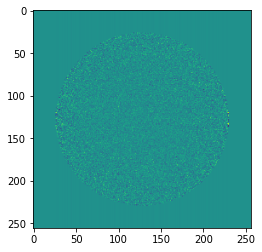

In [ ]:
# plt.imshow(hmi_sample)

In [ ]:
# hmi_test_sample = np.expand_dims(dataset[0][100], axis=0)
# hmi_test_sample.shape

(1, 256, 256, 1)

In [ ]:
# pred_aia = trained_model.predict(hmi_test_sample)

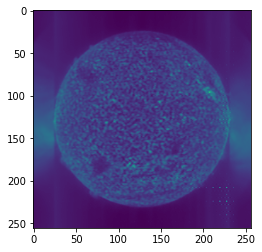

In [ ]:
# plt.imshow(pred_aia.reshape(256,256))

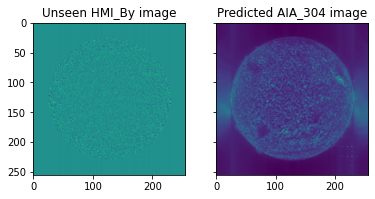

In [ ]:
# # Create two subplots and unpack the output array immediately

# f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

# ax1.imshow(hmi_sample)
# ax1.set_title('Unseen HMI_By image')
# ax2.imshow(pred_aia.reshape(256,256))
# ax2.set_title('Predicted AIA_304 image')
# plt.savefig('/content/drive/My Drive/solar_code_data_GAN/images_model/304_hmiY/prediction100.png', dpi=200)
# plt.show()